# Individual Assignment 2
### Objective
The goal of this homework is to get more hands-on practice with data cleaning and feature engineering, experience with classification trees and kNNs, and understanding of overfitting. You will:


1.   Clean and create additional features in the Airbnb dataset (which you will use for your project).
2.   Develop logistic regression, classification tree, and kNN models.
3. Construct fitting curves.
4. Select the model with the best performance.

----
### Dataset Information
The data in the accompanying file “airbnb_hw2.csv” (posted on Canvas) contains data from 10,000 Airbnb.com listings, mostly from the US. This is a larger subset of the data that you will eventually use for the class project. The data dictionary is available on ELMS.

Your task is to develop models to predict the target variable `high_booking_rate`, which labels whether a listing is popular (i.e. spends most of the time booked) or not.

Please answer the questions below clearly and concisely, providing tables or plots where applicable. Please submit a well-formatted jupyter notebook ***converted to an HTML file***, containing clear answers either in the form of text or code in the appropriate places to the questions.

To receive credit, your submitted code must work without any errors, its results should appear in the HTML file (i.e. make sure to run all cells before submission), and the entire document must be clear, concise and readable. You are free to use either Google Colab or Jupyter Notebook on your own computer

Note that this assignment is somewhat open-ended and there are many ways to answer these questions. I don’t require that we have exactly the same answers in order for you to receive full credit.

---

In [271]:
# Load necessary packages
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [272]:
# If you are using Jupyter notebook, you should change this path to the location
# of the file in your computer.
# If you are using Google Colab, then you should eiter mount your google drive
# and change this path to the location of the file in your drive.
# or upload the file to the virtual machine and change the path accordingly.
#from google.colab import drive
#drive.mount('/content/gdrive')

airbnb = pd.read_csv('airbnb_hw2.csv')

In [273]:
# Display column names
print(airbnb.columns)

Index(['name', 'accommodates', 'bed_type', 'bedrooms', 'beds',
       'cancellation_policy', 'cleaning_fee', 'host_total_listings_count',
       'price', 'property_type', 'room_type', 'high_booking_rate', 'bathrooms',
       'extra_people', 'host_acceptance_rate', 'host_is_superhost',
       'host_response_rate', 'minimum_nights', 'market'],
      dtype='object')


In [274]:
airbnb.head()

,name,accommodates,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,host_total_listings_count,price,property_type,room_type,high_booking_rate,bathrooms,extra_people,host_acceptance_rate,host_is_superhost,host_response_rate,minimum_nights,market
0,Cathy's Cozy Cottage,2,Real Bed,1.0,1.0,moderate,NaN,1.0,$75.00,House,Private room,1,1.0,$0.00,NaN,False,100%,2,Los Angeles
1,Private Entrance! Bay View! Quiet!,2,Real Bed,1.0,2.0,moderate,$50.00,2.0,$99.00,House,Private room,0,1.0,$0.00,92%,False,100%,1,San Diego
2,Beautiful Bohemian Getaway,5,Real Bed,1.0,3.0,moderate,$15.00,1.0,$75.00,Condominium,Private room,1,1.0,$12.00,97%,False,69%,1,San Diego
3,Lux Wash Park Home Gr8 4 families,10,Real Bed,5.0,8.0,strict,$100.00,1.0,$411.00,House,Entire home/apt,0,4.0,$50.00,NaN,False,100%,3,Denver
4,Huge private bedroom with park views,2,Real Bed,1.0,1.0,moderate,NaN,1.0,$75.00,Apartment,Private room,0,1.0,$0.00,NaN,False,100%,1,New York


# 0: Example answer
What is the mean of the accommodates variable?

*ANSWER TO QUESTION 0 HERE: The mean number of people that can be accommodated in a listing in this dataset is 3.5226.*

In [276]:
# Compute the mean of the accommodates variable
accommodates_mean = airbnb['accommodates'].mean()
print(f"Mean Accommodates: {accommodates_mean}")

Mean Accommodates: 3.5226


# 1: EDA and Data Cleaning
a). Repeat the data cleaning from HW1. You should be able to mostly reuse your code. As a reminder, this requires doing the following steps

(I recommend you do these in the order in which they are listed):


*   For `cancellation_policy`, group “strict” and “super_strict_30” into “strict”
*   Convert `cleaning_fee` and `price` into numbers.
*   Replace NAs in `cleaning_fee` and `price` with 0.
*   Replace NAs in other numerical variables with their mean.
*   Create the following new features:
  *   `price_per_person` is the nightly price per accommodates.
  *   `has_cleaning_fee` is YES if there is a cleaning fee, and NO otherwise.
  *   `bed_category` is “bed” if the `bed_type` is Real Bed and “other” otherwise.
  *   `property_category` has the following values:
      *   apartment if `property_type` is Apartment, Serviced apartment, Loft.
      *   hotel if `property_type` is Bed & Breakfast, Boutique hotel, Hostel.
      *   condo if `property_type` is Townhouse, Condominium.
      *   house if `property_type` is Bungalow, House.
      *   other, otherwise.
      
      make sure to convert `property_category` to a category!
  *   `ppp_ind` is 1 if the `price_per_person` is greater than the median for the `property_category`, and 0 otherwise.
  
Make sure these variables are categories: - `property_category` - `bed_category` - `cancellation_policy` - `room_type` - `ppp_ind`

*ANSER TO QUESTION 1a HERE:*

In [279]:
# For cancellation_policy, group "strict" and "super_strict_30" into "strict"
airbnb['cancellation_policy'] = airbnb['cancellation_policy'].replace({'super_strict_30': 'strict'})

# Convert cleaning_fee and price into numbers
airbnb['cleaning_fee'] = airbnb['cleaning_fee'].astype(str).str.replace(r'\$', '', regex=True).str.replace(',', '').str.strip().astype(float)
airbnb['price'] = airbnb['price'].astype(str).str.replace(r'\$', '', regex=True).str.replace(',', '').str.strip().astype(float)


# Replace NAs in cleaning_fee and price with 0
airbnb['cleaning_fee'] = airbnb['cleaning_fee'].fillna(0)
airbnb['price'] = airbnb['price'].fillna(0)

# Replace NAs in other numerical variables with their mean
airbnb.fillna({
    'accommodates': airbnb['accommodates'].mean(),
    'bedrooms': airbnb['bedrooms'].mean(),
    'beds': airbnb['beds'].mean(),
    'host_total_listings_count': airbnb['host_total_listings_count'].mean(),
    'high_booking_rate': airbnb['high_booking_rate'].mean()
}, inplace=True)

In [280]:
airbnb.head()

,name,accommodates,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,host_total_listings_count,price,property_type,room_type,high_booking_rate,bathrooms,extra_people,host_acceptance_rate,host_is_superhost,host_response_rate,minimum_nights,market
0,Cathy's Cozy Cottage,2,Real Bed,1.0,1.0,moderate,0.0,1.0,75.0,House,Private room,1,1.0,$0.00,NaN,False,100%,2,Los Angeles
1,Private Entrance! Bay View! Quiet!,2,Real Bed,1.0,2.0,moderate,50.0,2.0,99.0,House,Private room,0,1.0,$0.00,92%,False,100%,1,San Diego
2,Beautiful Bohemian Getaway,5,Real Bed,1.0,3.0,moderate,15.0,1.0,75.0,Condominium,Private room,1,1.0,$12.00,97%,False,69%,1,San Diego
3,Lux Wash Park Home Gr8 4 families,10,Real Bed,5.0,8.0,strict,100.0,1.0,411.0,House,Entire home/apt,0,4.0,$50.00,NaN,False,100%,3,Denver
4,Huge private bedroom with park views,2,Real Bed,1.0,1.0,moderate,0.0,1.0,75.0,Apartment,Private room,0,1.0,$0.00,NaN,False,100%,1,New York


In [281]:
# price_per_person
airbnb['price_per_person'] = airbnb['price'] / airbnb['accommodates']

# has_cleaning_fee
airbnb['has_cleaning_fee'] = airbnb['cleaning_fee'].apply(lambda x: 'YES' if x > 0 else 'NO')

# bed_category
airbnb['bed_category'] = airbnb['bed_type'].apply(lambda x: 'bed' if x == 'Real Bed' else 'other')

# property_category
def categorize_property(property_type):
    if property_type in ['Apartment', 'Serviced apartment', 'Loft']:
        return 'apartment'
    elif property_type in ['Bed & Breakfast', 'Boutique hotel', 'Hostel']:
        return 'hotel'
    elif property_type in ['Townhouse', 'Condominium']:
        return 'condo'
    elif property_type in ['Bungalow', 'House']:
        return 'house'
    else:
        return 'other'

airbnb['property_category'] = airbnb['property_type'].apply(lambda x: categorize_property(x))

# ppp_ind
median_ppp = airbnb.groupby('property_category')['price_per_person'].transform('median')
airbnb['ppp_ind'] = (airbnb['price_per_person'] > median_ppp).astype(int)

# Convert non-numeric variables to categorical type
categorical_col = ['property_category', 'bed_category', 'cancellation_policy', 'room_type', 'ppp_ind']
airbnb[categorical_col] = airbnb[categorical_col].astype('category')

In [282]:
airbnb.head()

,name,accommodates,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,host_total_listings_count,price,property_type,room_type,high_booking_rate,bathrooms,extra_people,host_acceptance_rate,host_is_superhost,host_response_rate,minimum_nights,market,price_per_person,has_cleaning_fee,bed_category,property_category,ppp_ind
0,Cathy's Cozy Cottage,2,Real Bed,1.0,1.0,moderate,0.0,1.0,75.0,House,Private room,1,1.0,$0.00,NaN,False,100%,2,Los Angeles,37.5,NO,bed,house,1
1,Private Entrance! Bay View! Quiet!,2,Real Bed,1.0,2.0,moderate,50.0,2.0,99.0,House,Private room,0,1.0,$0.00,92%,False,100%,1,San Diego,49.5,YES,bed,house,1
2,Beautiful Bohemian Getaway,5,Real Bed,1.0,3.0,moderate,15.0,1.0,75.0,Condominium,Private room,1,1.0,$12.00,97%,False,69%,1,San Diego,15.0,YES,bed,condo,0
3,Lux Wash Park Home Gr8 4 families,10,Real Bed,5.0,8.0,strict,100.0,1.0,411.0,House,Entire home/apt,0,4.0,$50.00,NaN,False,100%,3,Denver,41.1,YES,bed,house,1
4,Huge private bedroom with park views,2,Real Bed,1.0,1.0,moderate,0.0,1.0,75.0,Apartment,Private room,0,1.0,$0.00,NaN,False,100%,1,New York,37.5,NO,bed,apartment,0


In [283]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   name                       9999 non-null   object  
 1   accommodates               10000 non-null  int64   
 2   bed_type                   10000 non-null  object  
 3   bedrooms                   10000 non-null  float64 
 4   beds                       10000 non-null  float64 
 5   cancellation_policy        10000 non-null  category
 6   cleaning_fee               10000 non-null  float64 
 7   host_total_listings_count  10000 non-null  float64 
 8   price                      10000 non-null  float64 
 9   property_type              10000 non-null  object  
 10  room_type                  10000 non-null  category
 11  high_booking_rate          10000 non-null  int64   
 12  bathrooms                  9969 non-null   float64 
 13  extra_people               10000

b). Additional variables have been included in this dataset. Do the following steps to clean them in preparation for inclusion in models:

*   Replace NAs in `bathrooms` with the median value.
*   Replace NAs in `host_is_superhost` with FALSE.
*   Create a new (category) variable called `charges_for_extra` which has the value “YES” if `extra_people` > 0 and “NO” if `extra_people` is 0 or NA.
*   Create a new (category) variable called `host_acceptance` from `host_acceptance_rate` with the values “ALL” if `host_acceptance_rate` = 100%, “SOME” if `host_acceptance_rate` < 100%, and “MISSING” if it’s NA.
*   Similarly, create a new (category) variable called `host_response` with the values “ALL” if `host_response_rate` = 100%, “SOME” if `host_response_rate` < 100%, and “MISSING” if it’s NA.
*   Create a new categorical variable called `has_min_nights` which is “YES” if `minimum_nights` > 1, and “NO” otherwise
*   Replace `market` with “OTHER” if there are under 300 instances in that market. Convert `market` to a category.

Make sure to convert `high_booking_rate` to a category!

*ANSWER TO QUESTION 1b HERE:*

In [286]:

# Replace NAs in bathrooms with the median value
airbnb['bathrooms'] = airbnb['bathrooms'].fillna(airbnb['bathrooms'].median())

# Replace NAs in host_is_superhost with FALSE
airbnb['host_is_superhost'] = airbnb['host_is_superhost'].fillna(False)

# Convert extra_people to numeric
airbnb['extra_people'] = airbnb['extra_people'].astype(str).str.replace(r'\$', '', regex=True).astype(float)
airbnb['extra_people'] = pd.to_numeric(airbnb['extra_people'])

# charges_for_extra
airbnb['charges_for_extra'] = np.where((airbnb['extra_people'] > 0) | (airbnb['extra_people'].isna()), 'YES', 'NO')

# host_acceptance
airbnb['host_acceptance'] = np.where(airbnb['host_acceptance_rate'] == '100%', 'ALL', 
                                     np.where(airbnb['host_acceptance_rate'].isna(), 'MISSING', 'SOME'))

# host_response 
airbnb['host_response'] = np.where(airbnb['host_response_rate'] == '100%', 'ALL', 
                                  np.where(airbnb['host_response_rate'].isna(), 'MISSING', 'SOME'))

# has_min_nights
airbnb['has_min_nights'] = np.where(airbnb['minimum_nights'] > 1, 'YES', 'NO')

# Replace market with "OTHER" if there are under 300 instances in that market
market_counts = airbnb['market'].value_counts()
airbnb['market'] = np.where(airbnb['market'].isin(market_counts[market_counts < 300].index), 'OTHER', airbnb['market'])
airbnb['market'] = airbnb['market'].fillna('OTHER')

# Convert categorical variables to category type
categorical_columns = ['charges_for_extra', 'host_acceptance', 'host_response', 'has_min_nights', 'market', 'high_booking_rate']
airbnb[categorical_columns] = airbnb[categorical_columns].astype('category')

/var/folders/g4/5_2knr715298vxmcp_2c14_m0000gn/T/ipykernel_82142/3811890320.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  airbnb['host_is_superhost'] = airbnb['host_is_superhost'].fillna(False)


In [287]:
airbnb.head()

,name,accommodates,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,host_total_listings_count,price,property_type,room_type,high_booking_rate,bathrooms,extra_people,host_acceptance_rate,host_is_superhost,host_response_rate,minimum_nights,market,price_per_person,has_cleaning_fee,bed_category,property_category,ppp_ind,charges_for_extra,host_acceptance,host_response,has_min_nights
0,Cathy's Cozy Cottage,2,Real Bed,1.0,1.0,moderate,0.0,1.0,75.0,House,Private room,1,1.0,0.0,NaN,False,100%,2,Los Angeles,37.5,NO,bed,house,1,NO,MISSING,ALL,YES
1,Private Entrance! Bay View! Quiet!,2,Real Bed,1.0,2.0,moderate,50.0,2.0,99.0,House,Private room,0,1.0,0.0,92%,False,100%,1,San Diego,49.5,YES,bed,house,1,NO,SOME,ALL,NO
2,Beautiful Bohemian Getaway,5,Real Bed,1.0,3.0,moderate,15.0,1.0,75.0,Condominium,Private room,1,1.0,12.0,97%,False,69%,1,San Diego,15.0,YES,bed,condo,0,YES,SOME,SOME,NO
3,Lux Wash Park Home Gr8 4 families,10,Real Bed,5.0,8.0,strict,100.0,1.0,411.0,House,Entire home/apt,0,4.0,50.0,NaN,False,100%,3,Denver,41.1,YES,bed,house,1,YES,MISSING,ALL,YES
4,Huge private bedroom with park views,2,Real Bed,1.0,1.0,moderate,0.0,1.0,75.0,Apartment,Private room,0,1.0,0.0,NaN,False,100%,1,New York,37.5,NO,bed,apartment,0,NO,MISSING,ALL,NO


#2: Modeling Setup
a). Select the variables listed below from your dataframe - these will be the features used in our models (plus high_booking_rate, which is the target variable). Create a dataframe of dummy variables from the resulting set of variables.

Reminder: Categorical variables with more than two levels should be converted to multiple binary columns, called dummy variables. This process is also called onehot encoding. Ensure to include the argument drop_first=True when you call get_dummies() or drop='first' if you use OneHotEncoder() to drop the first category in each feature. Convert the dummy variable associated with high_booking_rate to a category.
* accommodates
* bedrooms
* beds
* cancellation_policy
* has_cleaning_fee
* host_total_listings_count
* price
* ppp_ind
* property_category
* bed_category
* bathrooms
* charges_for_extra
* host_acceptance
* host_response
* has_min_nights
* market
* host_is_superhost
* high_booking_rate

How many dummy variables do you end up with in your resulting data frame?

*ANSWER TO QUESTION 2a HERE:*

In [291]:
selected_columns = [
    'accommodates', 'bedrooms', 'beds', 'cancellation_policy', 'has_cleaning_fee',
    'host_total_listings_count', 'price', 'ppp_ind', 'property_category', 'bed_category',
    'bathrooms', 'charges_for_extra', 'host_acceptance', 'host_response',
    'has_min_nights', 'market', 'host_is_superhost', 'high_booking_rate'
]

airbnb_selected = airbnb[selected_columns].copy()
target_variable = airbnb_selected['high_booking_rate']

airbnb_encoded = pd.get_dummies(airbnb_selected.drop(columns=['high_booking_rate']), drop_first=True, dtype=int)

airbnb_encoded['high_booking_rate'] = target_variable.astype('category')

airbnb_encoded.head()

,accommodates,bedrooms,beds,host_total_listings_count,price,bathrooms,host_is_superhost,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_60,has_cleaning_fee_YES,ppp_ind_1,property_category_condo,property_category_hotel,property_category_house,property_category_other,bed_category_other,charges_for_extra_YES,host_acceptance_MISSING,host_acceptance_SOME,host_response_MISSING,host_response_SOME,has_min_nights_YES,market_Boston,market_Chicago,market_D.C.,market_Denver,market_Los Angeles,market_Nashville,market_New Orleans,market_New York,market_OTHER,market_Portland,market_San Diego,market_San Francisco,high_booking_rate
0,2,1.0,1.0,1.0,75.0,1.0,False,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2,1.0,2.0,2.0,99.0,1.0,False,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,5,1.0,3.0,1.0,75.0,1.0,False,1,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,10,5.0,8.0,1.0,411.0,4.0,False,0,1,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2,1.0,1.0,1.0,75.0,1.0,False,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [292]:
airbnb_encoded.columns

Index(['accommodates', 'bedrooms', 'beds', 'host_total_listings_count',
       'price', 'bathrooms', 'host_is_superhost',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_super_strict_60', 'has_cleaning_fee_YES',
       'ppp_ind_1', 'property_category_condo', 'property_category_hotel',
       'property_category_house', 'property_category_other',
       'bed_category_other', 'charges_for_extra_YES',
       'host_acceptance_MISSING', 'host_acceptance_SOME',
       'host_response_MISSING', 'host_response_SOME', 'has_min_nights_YES',
       'market_Boston', 'market_Chicago', 'market_D.C.', 'market_Denver',
       'market_Los Angeles', 'market_Nashville', 'market_New Orleans',
       'market_New York', 'market_OTHER', 'market_Portland',
       'market_San Diego', 'market_San Francisco', 'high_booking_rate'],
      dtype='object')

In [293]:
# Replace space and .
airbnb_encoded.columns = airbnb_encoded.columns.str.replace(' ', '_')
airbnb_encoded.columns = airbnb_encoded.columns.str.replace('.', '')

In [294]:
airbnb_encoded.columns

Index(['accommodates', 'bedrooms', 'beds', 'host_total_listings_count',
       'price', 'bathrooms', 'host_is_superhost',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_super_strict_60', 'has_cleaning_fee_YES',
       'ppp_ind_1', 'property_category_condo', 'property_category_hotel',
       'property_category_house', 'property_category_other',
       'bed_category_other', 'charges_for_extra_YES',
       'host_acceptance_MISSING', 'host_acceptance_SOME',
       'host_response_MISSING', 'host_response_SOME', 'has_min_nights_YES',
       'market_Boston', 'market_Chicago', 'market_DC', 'market_Denver',
       'market_Los_Angeles', 'market_Nashville', 'market_New_Orleans',
       'market_New_York', 'market_OTHER', 'market_Portland',
       'market_San_Diego', 'market_San_Francisco', 'high_booking_rate'],
      dtype='object')

In [295]:
numeric_columns = ['accommodates', 'bedrooms', 'beds', 'host_total_listings_count',
                   'price', 'bathrooms', 'high_booking_rate'] 

# Count dummy variables 
num_dummy_variables = len([col for col in airbnb_encoded.columns if col not in numeric_columns])
print(f"Total number of dummy variables: {num_dummy_variables}")

Total number of dummy variables: 29


b). Split your data into 70% training, 30% validation.

Before splitting the data, set the random seed to 1 using the code below. This ensure everybody gets the same random split.
```
np.random.seed(1)
```

In [297]:
# Convert high_booking_rate to numeric
airbnb_encoded['high_booking_rate'] = pd.to_numeric(airbnb_encoded['high_booking_rate'], errors='coerce')
airbnb_encoded['host_is_superhost'] = airbnb_encoded['host_is_superhost'].astype(int)

In [298]:
from sklearn.model_selection import train_test_split

np.random.seed(1)

train_data, validation_data = train_test_split(airbnb_encoded, test_size=0.3, random_state=np.random.seed(1))

print(f"Training data size: {train_data.shape}")
print(f"Validation data size: {validation_data.shape}")

Training data size: (7000, 36)
Validation data size: (3000, 36)


c). Train a logistic regression model to predict `high_booking_rate` in the training data (using the remaining variables as predictors). Report the accuracy in the validation data.

*ANSWER TO QUESTION 2c HERE:*

In [301]:
import statsmodels.formula.api as smf
logit_model = smf.logit(
    'high_booking_rate ~ accommodates + bedrooms + beds + host_total_listings_count + price + '
    'bathrooms + host_is_superhost + cancellation_policy_moderate + cancellation_policy_strict + '
    'cancellation_policy_super_strict_60 + has_cleaning_fee_YES + ppp_ind_1 + '
    'property_category_condo + property_category_hotel + property_category_house + '
    'property_category_other + bed_category_other + charges_for_extra_YES + '
    'host_acceptance_MISSING + host_acceptance_SOME + host_response_MISSING + '
    'host_response_SOME + has_min_nights_YES + market_Boston + market_Chicago + '
    'market_DC + market_Denver + market_Los_Angeles + market_Nashville + '
    'market_New_Orleans + market_New_York + market_OTHER + market_Portland + '
    'market_San_Diego + market_San_Francisco', 
    data=train_data
).fit(maxiter=5000)
print(logit_model.summary2())

         Current function value: 0.458153
         Iterations: 5000
                                           Results: Logit
Model:                         Logit                        Method:                      MLE        
Dependent Variable:            high_booking_rate            Pseudo R-squared:            0.177      
Date:                          2025-03-09 21:03             AIC:                         6486.1485  
No. Observations:              7000                         BIC:                         6732.8805  
Df Model:                      35                           Log-Likelihood:              -3207.1    
Df Residuals:                  6964                         LL-Null:                     -3896.3    
Converged:                     0.0000                       LLR p-value:                 3.8362e-267
No. Iterations:                5000.0000                    Scale:                       1.0000     
------------------------------------------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [302]:
logit_aic = logit_model.aic

print("\nLogistic Regression Model:")
print(f"AIC: {logit_aic:.4f}")


Logistic Regression Model:
AIC: 6486.1485


In [303]:
from sklearn.metrics import mean_squared_error

train_pred_logit_model = logit_model.predict(train_data)
test_pred_logit_model = logit_model.predict(validation_data)

train_rmse_log = np.sqrt(mean_squared_error(train_data['high_booking_rate'], train_pred_logit_model))
test_rmse_log = np.sqrt(mean_squared_error(validation_data['high_booking_rate'], test_pred_logit_model))

print("\nLogistic regression model:")
print(f"Train RMSE: {train_rmse_log:.4f}")
print(f"Test RMSE: {test_rmse_log:.4f}")


Logistic regression model:
Train RMSE: 0.3902
Test RMSE: 0.3884


In [304]:
from sklearn.metrics import accuracy_score

test_pred_logit_class = (test_pred_logit_model >= 0.5).astype(int)

validation_accuracy = accuracy_score(validation_data['high_booking_rate'], test_pred_logit_class)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Validation Accuracy: 0.7763


# 3: Classification trees

a). Use the following code to create an unpruned tree (uncomment the line starting with “full_tree…”). How many terminal nodes are in the full tree? Which variable has the highest-information gain (leads to the biggest decrease in impurity)? How do you know?

*ANSWER TO QUESTION 3a HERE:*

In [307]:
X_train  = train_data.drop(columns = ['high_booking_rate'], axis = 1)
y_train = train_data['high_booking_rate']
X_test = validation_data.drop(columns = ['high_booking_rate'], axis = 1)
y_test = validation_data['high_booking_rate']

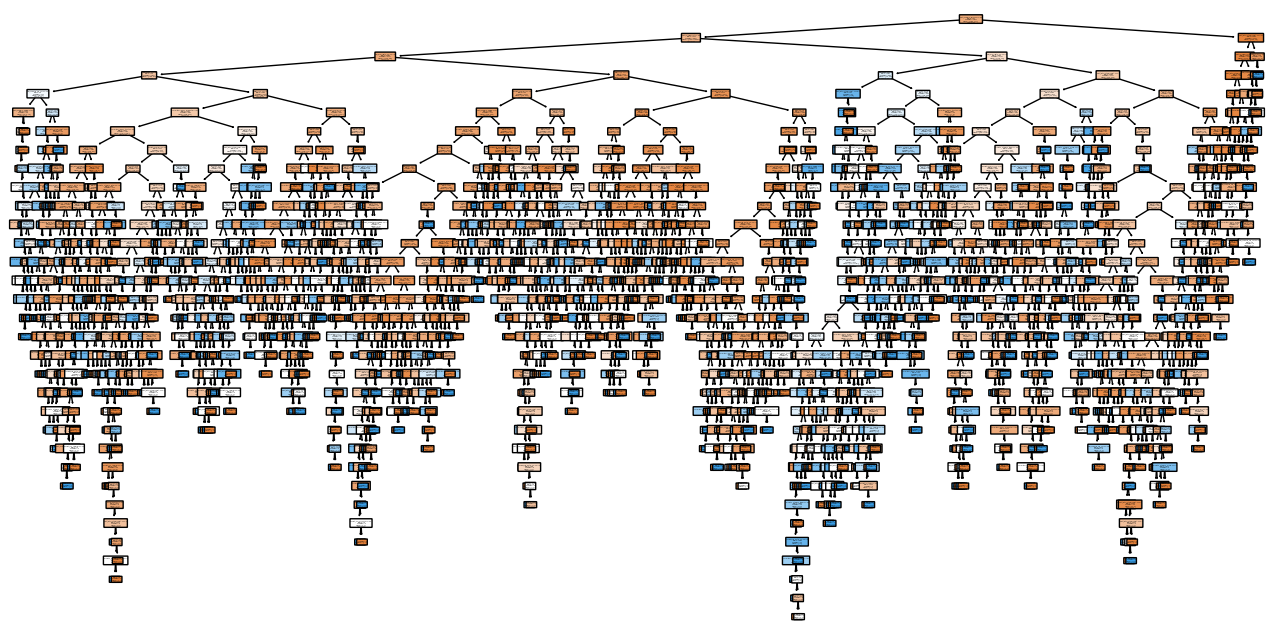

Full tree has 1660 leaves, 3319 nodes, 1659 decision/internal nodes, and a depth of 32.


In [308]:
tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=1
)

tree.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(16,8))
plot_tree(tree,
          filled=True,
          feature_names=train_data.columns,
          class_names=["NO", "YES"],
          rounded=True,
          fontsize=1)
plt.show()

num_leaves = tree.get_n_leaves()
num_nodes = tree.tree_.node_count
num_decision_nodes = num_nodes - num_leaves
depth = tree.get_depth()
print(f'Full tree has {num_leaves} leaves, {num_nodes} nodes, {num_decision_nodes} '
      f'decision/internal nodes, and a depth of {depth}.')

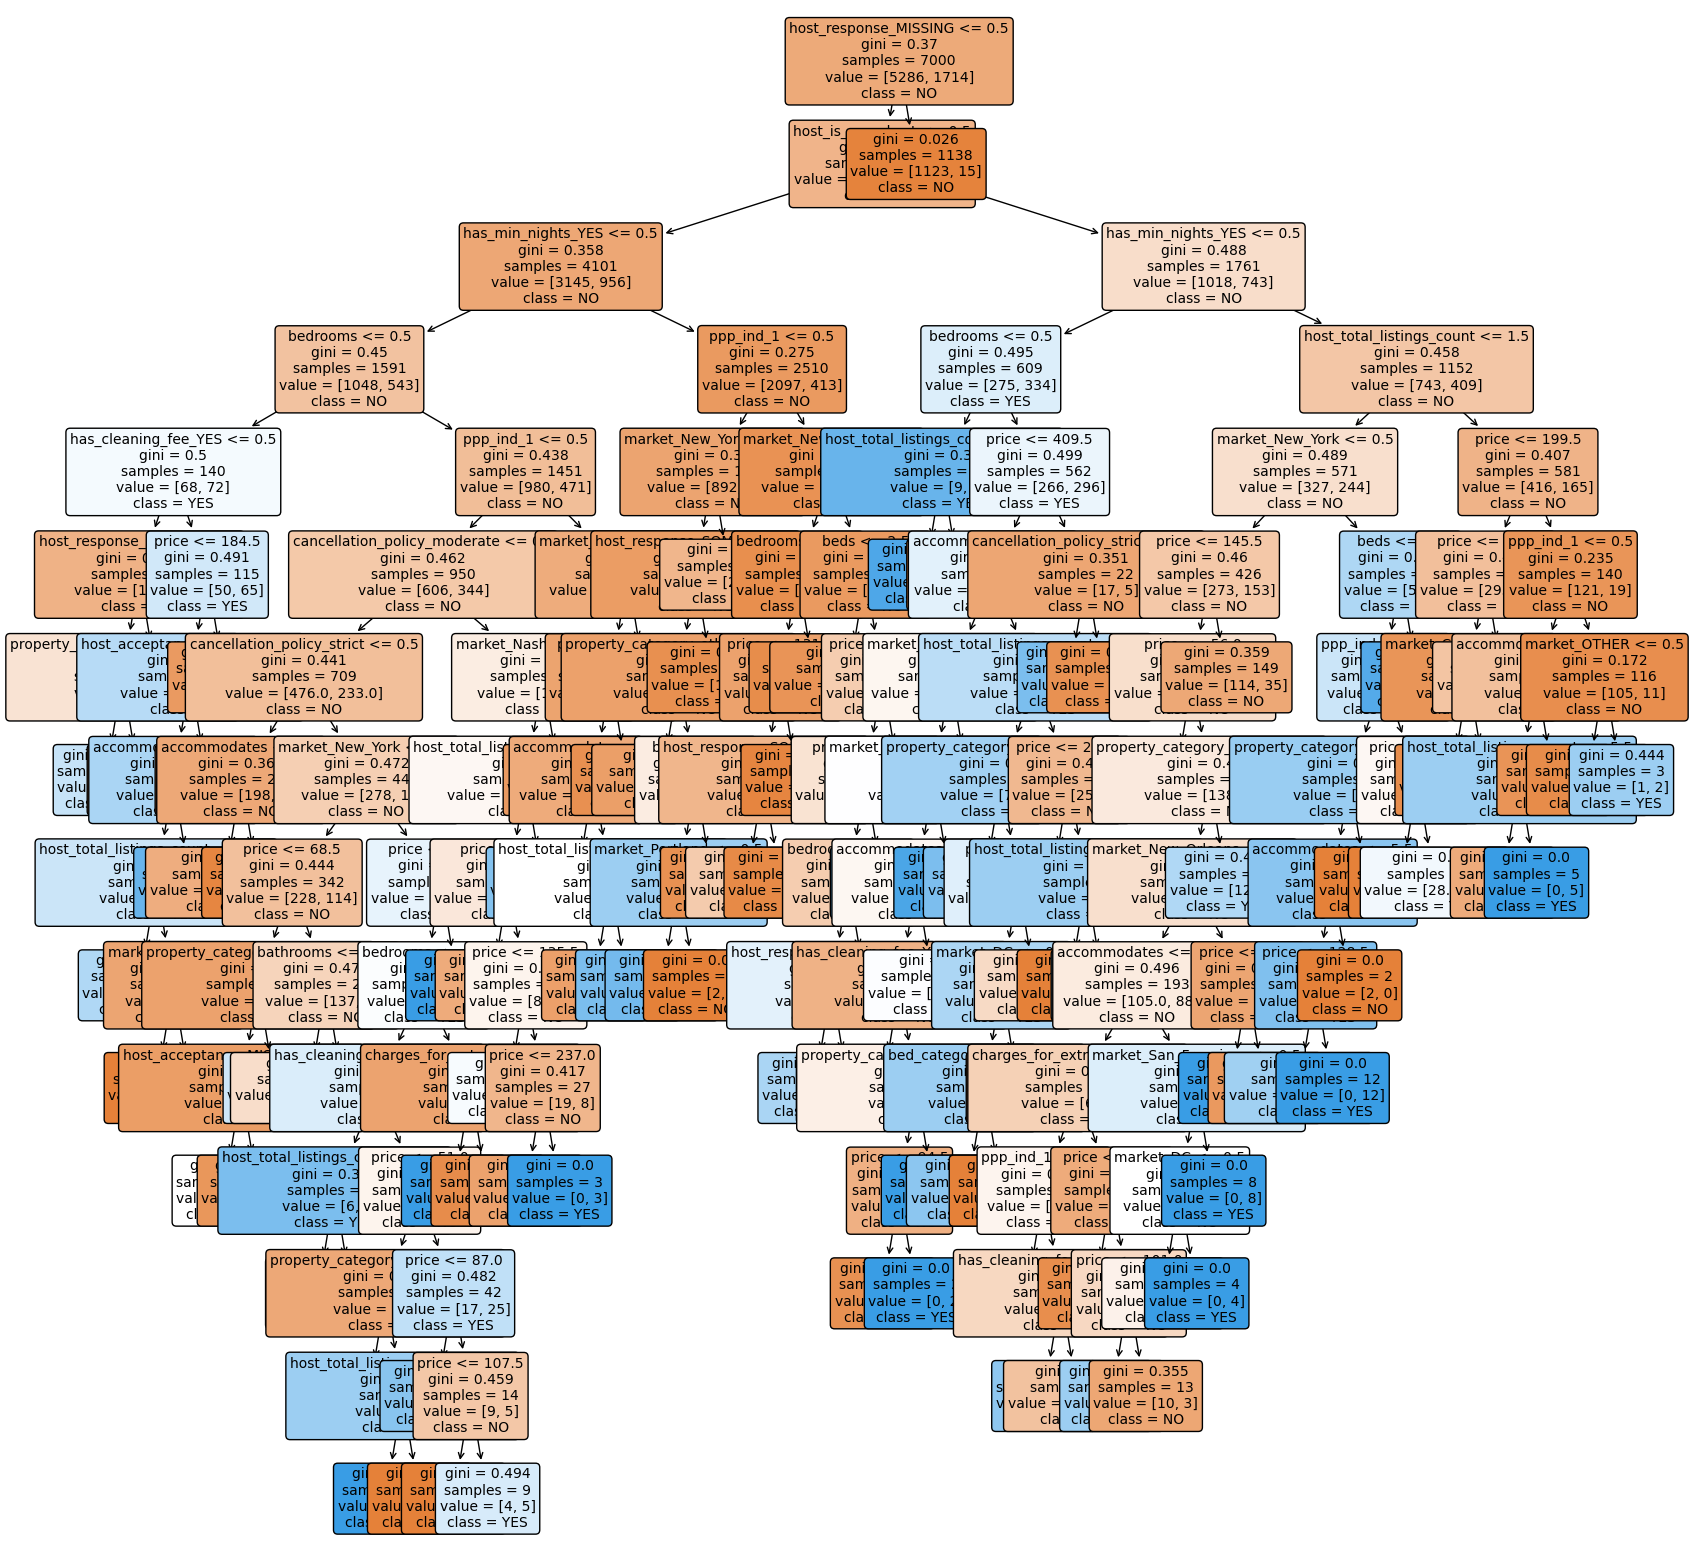

Full tree has 103 leaves, 205 nodes, 102 decision/internal nodes, and a depth of 14.
The variable with the highest information gain: host_response_MISSING


In [309]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

full_tree = DecisionTreeClassifier(
    criterion="gini",  
    min_samples_split=2,  
    min_samples_leaf=1, 
    min_impurity_decrease=0.00028, 
    random_state=42 
)

# Train model
full_tree.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(full_tree,
          filled=True,
          feature_names=train_data.columns,
          class_names=["NO", "YES"],
          rounded=True,
          fontsize=10)
plt.show()

num_leaves = full_tree.get_n_leaves()
num_nodes = full_tree.tree_.node_count
num_decision_nodes = num_nodes - num_leaves
depth = full_tree.get_depth()
print(f'Full tree has {num_leaves} leaves, {num_nodes} nodes, {num_decision_nodes} '
      f'decision/internal nodes, and a depth of {depth}.')

# feature with the highest information gain
most_important_feature = X_train.columns[full_tree.feature_importances_.argmax()]
print(f'The variable with the highest information gain: {most_important_feature}')

b). Create pruned trees of size 2, 4, 6, 8, 10, 15, 20, 25, 30, 35, and 40. Plot fitting curves consisting of the accuracy in the validation and training sets for each pruned tree (assuming a cutoff of 0.5). Make sure the two sets of points are different colors.

Hint: you might want to change the y-axis of your plot from the default by adding the ylim() argument to plot().

*ANSWER TO QUESTION 3b HERE:*

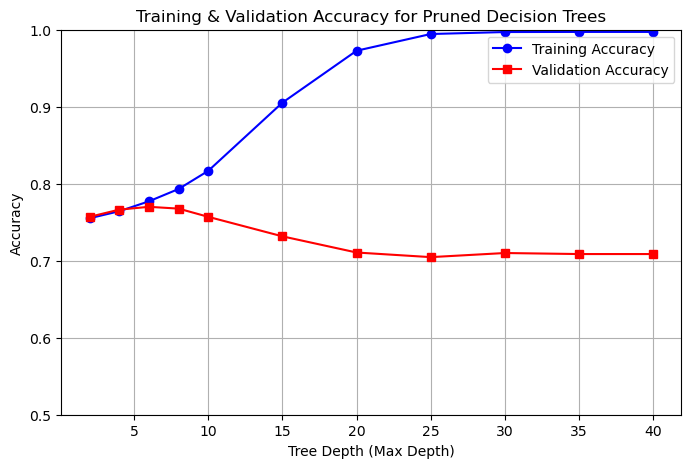

In [312]:
# tree sizes 
tree_sizes = [2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40]

train_accuracies = []
valid_accuracies = []

for size in tree_sizes:
    pruned_tree = DecisionTreeClassifier(max_depth=size, random_state=42)
    pruned_tree.fit(X_train, y_train)
    train_pred = pruned_tree.predict(X_train)
    valid_pred = pruned_tree.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    valid_acc = accuracy_score(y_test, valid_pred)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(tree_sizes, train_accuracies, marker='o', linestyle='-', color='blue', label="Training Accuracy")
plt.plot(tree_sizes, valid_accuracies, marker='s', linestyle='-', color='red', label="Validation Accuracy")

plt.xlabel("Tree Depth (Max Depth)")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy for Pruned Decision Trees")
plt.legend()
plt.ylim(0.5, 1)  
plt.grid(True)

plt.show()

c). Which tree size is the best, and how did you select the best one? Report the validation accuracy of your best tree. Which would you choose if you needed to create a model to predict high_booking_rate - the best tree, or your logistic regression from above?

*ANSWER TO QUESTION 3c HERE:*

In [315]:
# Identify the best tree size
best_tree_index = np.argmax(valid_accuracies) 
best_tree_size = tree_sizes[best_tree_index] 
best_validation_accuracy = valid_accuracies[best_tree_index]

print(f"Best tree size: {best_tree_size}")
print(f"Best tree accuracy: {best_validation_accuracy:.4f}")

Best tree size: 6
Best tree accuracy: 0.7700


I would choose logistic regression to predict high_booking_rate because it has the highest validation accuracy of 77.63%, making it the most reliable model. Additionally, logistic regression is more interpretable which makes it better for understanding feature importance and relationships. 

# 4. kNN

a). Set up for running kNN by separating the training and validation X matrices from the y variables.

*ANSWER TO QUESTION 4a HERE:*

In [320]:
X_train_knn = train_data.drop(columns=['high_booking_rate'])
y_train_knn = train_data['high_booking_rate']

X_valid_knn = validation_data.drop(columns=['high_booking_rate'])
y_valid_knn = validation_data['high_booking_rate']

print(f"X_train shape: {X_train_knn.shape}, y_train shape: {y_train_knn.shape}")
print(f"X_valid shape: {X_valid_knn.shape}, y_valid shape: {y_valid_knn.shape}")

X_train shape: (7000, 35), y_train shape: (7000,)
X_valid shape: (3000, 35), y_valid shape: (3000,)


b). Compute kNN estimates in the training and validation data using k values of 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50, 100, and 200. Make sure the two sets of points are different colors! Once again, you might want to play with the ylim() on your graph. It also might help to plot the log(k) on the x-axis rather than just k.


Note: kNN will take a little more time than logistic regression or trees to run, so be patient!

*ANSWER TO QUESTION 4b HERE:*

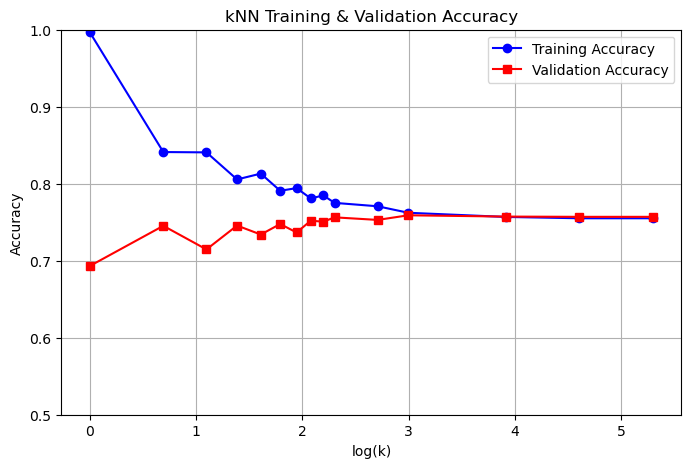

In [323]:
# k values 
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50, 100, 200]

train_accuracies = []
valid_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train_knn)
    train_pred = knn.predict(X_train_knn)
    valid_pred = knn.predict(X_valid_knn)
    train_acc = accuracy_score(y_train_knn, train_pred)
    valid_acc = accuracy_score(y_valid_knn, valid_pred)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

# Plot 
plt.figure(figsize=(8, 5))
plt.plot(np.log(k_values), train_accuracies, marker='o', linestyle='-', color='blue', label="Training Accuracy")
plt.plot(np.log(k_values), valid_accuracies, marker='s', linestyle='-', color='red', label="Validation Accuracy")

plt.xlabel("log(k)")
plt.ylabel("Accuracy")
plt.title("kNN Training & Validation Accuracy")
plt.legend()
plt.ylim(0.5, 1) 
plt.grid(True)

plt.show()

c). Which k is the best? Report the validation accuracy from the best kNN model. Are you satisfied with the values of k that you tried, or do you think it might improve your model to try more values of k?

*ANSWER TO QUESTION 4c HERE:*

In [326]:
# Identify the best k 
best_k_index = np.argmax(valid_accuracies)  
best_k = k_values[best_k_index]  
best_validation_accuracy = valid_accuracies[best_k_index]  

print(f"Best k: {best_k}")
print(f"Best k validation accuracy: {best_validation_accuracy:.4f}")

Best k: 20
Best k validation accuracy: 0.7590


We can see from the graph that as k increases, training accuracy drops and validation accuracy improves, peaking around k=20, before leveling off. This indicates that k=20 is a good choice, as it balances underfitting and overfitting. However, exploring more values such as k=25 or k=30 might improve the models performance. 

d). Now which model would you pick - the best kNN, the best decision tree, or logistic regression?

*ANSWER TO QUESTION 4d HERE:*

Logistic regression (0.7763 accuracy) performs better than the decision tree (0.7700) and kNN (0.7590) as logistic regression has the highest accuracy. Logistic regression is interpretable as it allows us to understand how each feature influences the outcome. Whereas, decision trees is more prone to overfitting and kNN is extremely sensitive to outliers or mislabeled points. Hence, Logistic regression is the model I would pick. 